In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy 

In [2]:
# https://www.kaggle.com/competitions/spaceship-titanic/overview
def load_data():
    train_path = os.path.join('Datasets', 'train.csv')
    test_path = os.path.join('Datasets', 'test.csv')
    
    return pd.read_csv(train_path), pd.read_csv(test_path)

def split_passengerId(df):
    df['Position'] = df['PassengerId'].str[-2:]
    df['Group'] = df['PassengerId'].str[:4]
    df.drop(['PassengerId'], axis=1, inplace=True)  
    
def clean_cryosleep(df):
    indicies = df.loc[(df['CryoSleep'].isnull()) & ((df['FoodCourt']!=0) | (df['RoomService']!=0)
                                     | (df['ShoppingMall']!=0) | (df['Spa']!=0)
                                    | (df['VRDeck']!=0) )].index
    df.loc[indicies, 'CryoSleep'] = False

def split_cabin(df):
    df['Deck'] = df['Cabin'].str.split('/', expand=True)[0]
    df['CabinNumber'] = df['Cabin'].str.split('/', expand=True)[1]
    df['CabinSide'] = df['Cabin'].str.split('/', expand=True)[2]
    df.drop(['Cabin'], axis=1, inplace=True)

def fill_homeplanet(df):   
    df2 = df.loc[df['HomePlanet'].notnull()]
    homeplanet_dict = dict(zip(df2['Group'],df2['HomePlanet']))

    df['New_HomePlanet'] = np.where(df['HomePlanet'].isnull(),df['Group'].map(homeplanet_dict),df['HomePlanet'])
    df.drop(['HomePlanet'], axis=1, inplace=True)
    df.rename(columns={'New_HomePlanet':'HomePlanet'}, inplace=True)
    df['HomePlanet'] = df[['HomePlanet']].fillna('Unknown')    


In [3]:
def clean_data(df):
    split_passengerId(df)
    split_cabin(df)
    clean_cryosleep(df)
    fill_homeplanet(df)
    
    df['TotalSpending'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df.drop(['Name'], axis=1, inplace=True)

In [4]:

train_data, test_data = load_data()


# Dropping data is just temporary, maybe add an imputer or find a workaround for some fields
clean_data(train_data)
train_data = train_data.dropna()

clean_data(test_data)
test_data = test_data.dropna()


X_train = train_data.loc[:, train_data.columns!='Transported']
y_train = train_data['Transported']
X_test = test_data.loc[:, test_data.columns!='Transported']





spaceship = X_train.copy()
spaceship_labels = y_train.copy()

In [5]:
# Need to remove all nulls
spaceship.isna().sum()

CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Position         0
Group            0
Deck             0
CabinNumber      0
CabinSide        0
HomePlanet       0
TotalSpending    0
dtype: int64

In [6]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Use column transformer when you need to do preprocessing on different type of columns
# such as standardizing numerical columns and hot encoding categories
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


spaceship_num = list(spaceship[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck',
                                'TotalSpending','Position','Group','CabinNumber']])
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())   
])


spaceship_cats = list(spaceship[['CryoSleep','Destination','VIP','Deck','CabinSide', 'HomePlanet']])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, spaceship_num),
    ('encode', OneHotEncoder(), spaceship_cats)
],remainder='passthrough')

spaceship_prepared = full_pipeline.fit_transform(spaceship)
# As you can see it returns as dtype 'sparse matrix' which can be converted to
# a NumPy array with toarray()

In [7]:
full_pipeline.get_feature_names_out()

array(['num__Age', 'num__RoomService', 'num__FoodCourt',
       'num__ShoppingMall', 'num__Spa', 'num__VRDeck',
       'num__TotalSpending', 'num__Position', 'num__Group',
       'num__CabinNumber', 'encode__CryoSleep_False',
       'encode__CryoSleep_True', 'encode__Destination_55 Cancri e',
       'encode__Destination_PSO J318.5-22',
       'encode__Destination_TRAPPIST-1e', 'encode__VIP_False',
       'encode__VIP_True', 'encode__Deck_A', 'encode__Deck_B',
       'encode__Deck_C', 'encode__Deck_D', 'encode__Deck_E',
       'encode__Deck_F', 'encode__Deck_G', 'encode__Deck_T',
       'encode__CabinSide_P', 'encode__CabinSide_S',
       'encode__HomePlanet_Earth', 'encode__HomePlanet_Europa',
       'encode__HomePlanet_Mars', 'encode__HomePlanet_Unknown'],
      dtype=object)

In [8]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(spaceship_prepared, spaceship_labels)


LogisticRegression()

In [9]:
# Testing the model on some data
some_data = spaceship.iloc[:5]
some_labels = spaceship_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', log_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [ True False False False False]
Labels: [False, True, False, False, True]


In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(spaceship_prepared, spaceship_labels)

SGDClassifier(random_state=42)

In [11]:
# Evaluate model by splitting training set into k folds (in this case 3)
# then predicting and evaluating them
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, spaceship_prepared, spaceship_labels, cv=3, scoring='accuracy')

array([0.77294067, 0.77976953, 0.73538199])

In [12]:
# True Positive [good] , False Negative [Bad]
# False Positive [Bad] , True Negative [Good]
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

spaceship_labels_pred = cross_val_predict(sgd_clf, spaceship_prepared, spaceship_labels, cv=3)
confusion_matrix(spaceship_labels, spaceship_labels_pred)

array([[2364, 1153],
       [ 515, 2997]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import f1_score

# If you need a model that CANNOT have a wrong TRUE prediction, you want a high precision
print('How often were the TRUE predictions correct? ', round(precision_score(spaceship_labels, spaceship_labels_pred),4)*100)
# If you want a model that needs to catch as many TRUE as possible, you want a high recall
print('What % of actual TRUE were detected? ' ,round(recall_score(spaceship_labels, spaceship_labels_pred),4)*100)
# This is the harmonic mean of precision and recall
print('F1 score is ', round(f1_score(spaceship_labels, spaceship_labels_pred),4)*100)


How often were the TRUE predictions correct?  72.22
What % of actual TRUE were detected?  85.34
F1 score is  78.23


In [14]:
# The decision of a predictor depends on if the score it assigns is higher than a threshold
# we cannot set the scikit threshold, but we can see the score it assigns and model our
# own threshold. By default the threshold is 0
label_score = sgd_clf.decision_function(spaceship_prepared[0].reshape(1,-1))
print(f'Threshold for this indvidual is: {label_score}')

threshold = 0
label_some_passenger_pred = (label_score > threshold)
print(label_some_passenger_pred)

threshold = 1
label_some_passenger_pred = (label_score > threshold)
print(label_some_passenger_pred)

Threshold for this indvidual is: [0.47768354]
[ True]
[False]


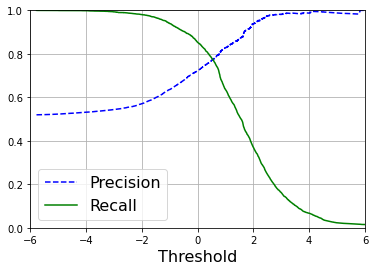

In [15]:
# How do we know what threshold to use?
label_scores = cross_val_predict(sgd_clf, spaceship_prepared, spaceship_labels, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(spaceship_labels, label_scores)

def plt_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-6, 6, 0, 1])            
    
plt_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

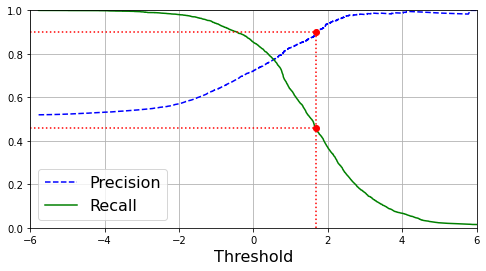

In [16]:
# We can set a threshold to get whatever precision we want
# However high precision isn't always useful if it means low recall
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plt_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-6, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-6, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")       
plt.show()

In [17]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
label_train_pred_90 = (label_scores >= threshold_90_precision)

print('Threshold for 90% precision :', round(threshold_90_precision,4))
print('How often were the TRUE predictions correct? ', round(precision_score(spaceship_labels, label_train_pred_90),4)*100)
print('What % of actual TRUE were detected? ' ,round(recall_score(spaceship_labels, label_train_pred_90),4)*100)

Threshold for 90% precision : 1.6726
How often were the TRUE predictions correct?  90.03999999999999
What % of actual TRUE were detected?  45.81


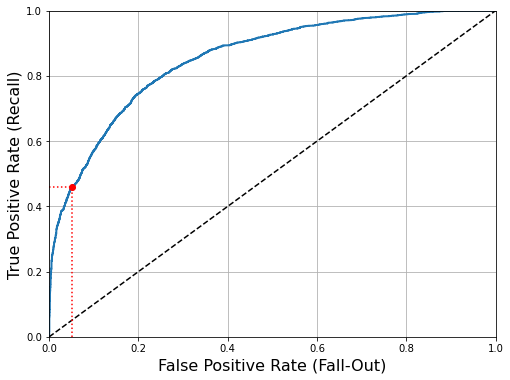

In [18]:
# Receiver Operating Characteristic (ROC)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds2 = roc_curve(spaceship_labels, label_scores)

def plt_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True) 

plt.figure(figsize=(8, 6))
plt_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)] 
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") 
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")          
plt.show()

In [19]:
# ROC Area Under Curve is another way to evaluate
# Should NOT use this when positive class is rare or care more about minimizing false positives
from sklearn.metrics import roc_auc_score

print('ROC score is ', round(roc_auc_score(spaceship_labels, label_scores),4)*100)

ROC score is  85.53


In [20]:
#Random Forest Classifier returns probabilites for classes instead of scores
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
label_probs_forest = cross_val_predict(forest_clf, spaceship_prepared, spaceship_labels, cv=3, method='predict_proba')

In [21]:
# ROC curve expects scores, but we can provide probabilities instead
label_scores_forest = label_probs_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(spaceship_labels, label_scores_forest)

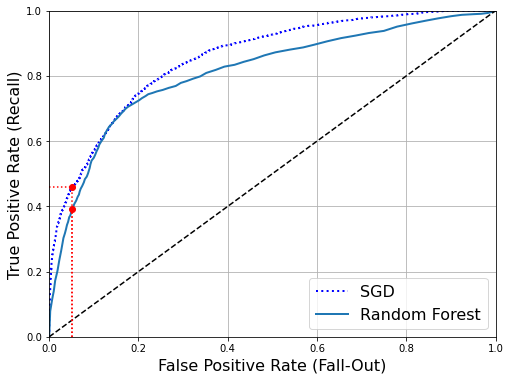

In [22]:
# Compare ROC from SGD model and Random Forest model
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plt_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [23]:
# ROC for the Random Forest is very high
print('ROC score is ', round(roc_auc_score(spaceship_labels, label_scores_forest),4)*100)

ROC score is  81.2


In [24]:
label_train_pred_forest = cross_val_predict(forest_clf, spaceship_prepared, spaceship_labels, cv=3)

print('How often were the TRUE predictions correct? ', round(precision_score(spaceship_labels, label_train_pred_forest),4)*100)
print('What % of actual TRUE were detected? ' ,round(recall_score(spaceship_labels, label_train_pred_forest),4)*100)

How often were the TRUE predictions correct?  82.75
What % of actual TRUE were detected?  64.35
